In [51]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

import matplotlib.pyplot as plt


In [61]:
df = pd.read_csv("../data/processed/marketing_campaign_processed.csv")

In [62]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,TotalSpending,TotalAcceptedCmp,CampaignSuccessRate,IsParent,CustomerTenure,Churn,CLV,SpendingToIncome,HighValue,PurchaseActivity
0,Graduation,Single,58138.0,0,0,635,88,546,172,88,...,1617,1,0.166667,0,663,1,2.435241,0.027813,1,29
1,Graduation,Single,46344.0,1,1,11,1,6,2,1,...,27,0,0.000000,1,113,0,0.236842,0.000583,0,9
2,Graduation,Together,71613.0,0,0,426,49,127,111,21,...,776,0,0.000000,0,312,0,2.479233,0.010836,0,24
3,Graduation,Together,26646.0,1,0,11,4,20,10,3,...,53,0,0.000000,1,139,0,0.378571,0.001989,0,12
4,PhD,Married,58293.0,1,0,173,43,118,46,27,...,422,0,0.000000,1,161,1,2.604938,0.007239,0,19


In [63]:
education_order = {
    'Basic': 1,
    '2n Cycle': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}

df['Education'] = df['Education'].map(education_order)
df['Education'].unique()


array([3, 5, 4, 1, 2])

In [64]:
# Hedef değişken
y = df['Churn']

# Özellikler
X = df.drop(columns=['Churn'])
X.shape, y.shape


((2240, 34), (2240,))

In [65]:
cols_to_drop = [
    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
    'Response', 'Complain', 
    'Kidhome', 'Teenhome'
]
cols_to_drop += [
    'MntWines', 'MntFruits', 'MntMeatProducts', 
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]


In [66]:
X = X.drop(cols_to_drop,axis=1)

In [67]:
X_encoded = pd.get_dummies(X, columns=["Marital_Status"], drop_first=True)

X_encoded.head()


,Education,Income,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,FamilySize,TotalSpending,...,SpendingToIncome,HighValue,PurchaseActivity,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,3,58138.0,3,8,10,4,7,68,2,1617,...,0.027813,1,29,False,False,False,True,False,False,False
1,3,46344.0,2,1,1,2,5,71,4,27,...,0.000583,0,9,False,False,False,True,False,False,False
2,3,71613.0,1,8,2,10,4,60,2,776,...,0.010836,0,24,False,False,False,False,True,False,False
3,3,26646.0,2,2,0,4,6,41,3,53,...,0.001989,0,12,False,False,False,False,True,False,False
4,5,58293.0,5,5,3,6,5,44,3,422,...,0.007239,0,19,False,False,True,False,False,False,False


In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((1792, 25), (448, 25))

In [69]:
param_grid = {
    'n_estimators': [100, 200, 300 , 500],
    'max_depth': [None, 10, 20, 40 ,80],
    'min_samples_split': [2, 5, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2']
}


In [70]:
rf_base = RandomForestClassifier(random_state=42)

grid_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
)


In [71]:
grid_search.fit(X_train, y_train)


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [72]:
grid_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40}

In [73]:
grid_search.best_score_


np.float64(0.6279876169985672)

In [74]:
best_rf = grid_search.best_estimator_

best_rf.fit(X_train, y_train)

y_pred_best = best_rf.predict(X_test)
y_pred_best_prob = best_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_best_prob))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Accuracy: 0.625
F1 Score: 0.7133105802047781
ROC-AUC: 0.6556061725355002

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.38      0.46       186
           1       0.65      0.80      0.71       262

    accuracy                           0.62       448
   macro avg       0.61      0.59      0.59       448
weighted avg       0.61      0.62      0.61       448



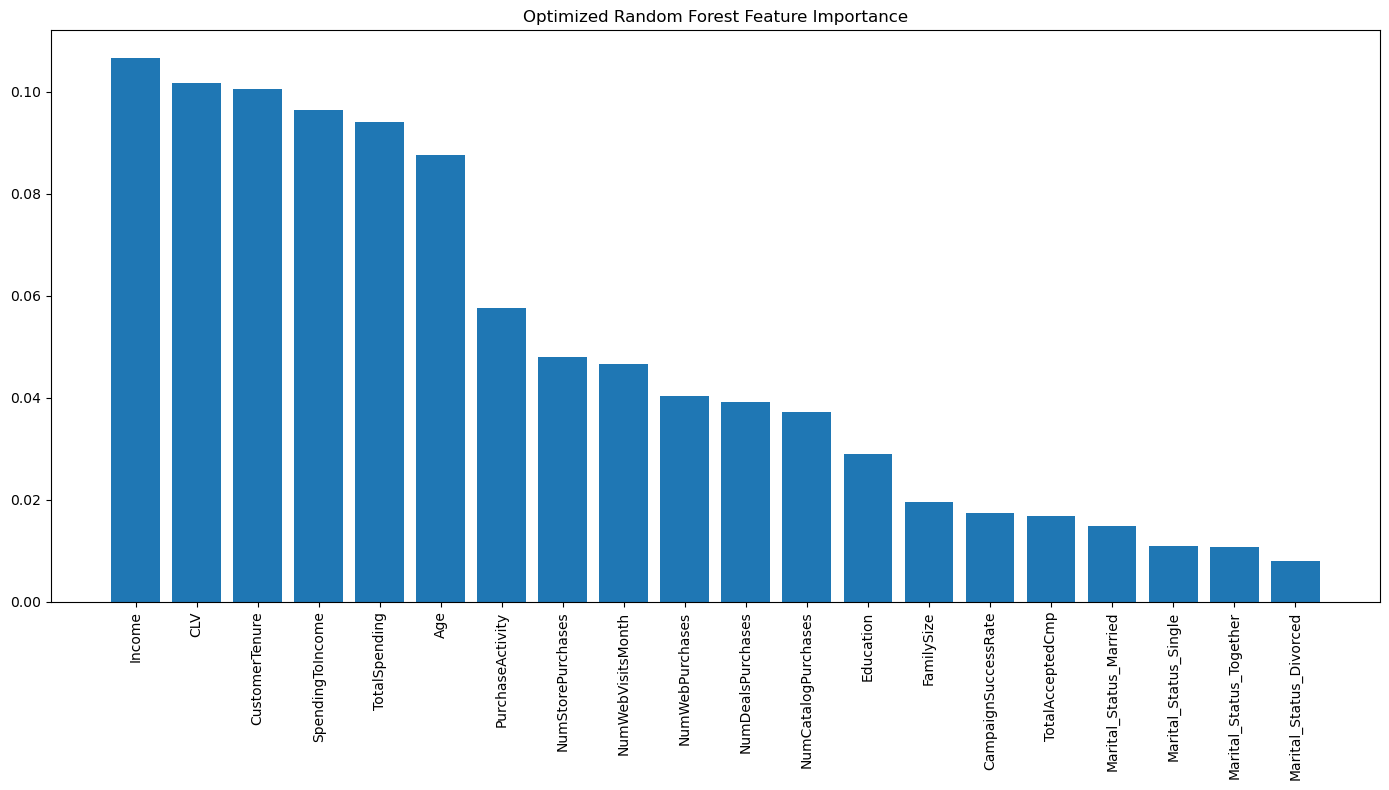

In [75]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_encoded.columns

plt.figure(figsize=(14, 8))
plt.title("Optimized Random Forest Feature Importance")
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), feature_names[indices][:20], rotation=90)
plt.tight_layout()
plt.show()
